## Preparando el entorno 

In [ ]:
#%pip install pandas matplotlib seaborn requests plotly numpy scikit-learn

## Extrayendo los datos de una api 

In [ ]:
import pandas as pd
import requests

# URL del JSON crudo desde GitHub (versión RAW)
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

# Obtener datos con requests
response = requests.get(url)
data = response.json()  # Convertimos la respuesta en JSON

# Convertir a DataFrame
df = pd.DataFrame(data)

# Mostrar las primeras filas
df.head()

## Conociendo el DataFrame 

In [ ]:
print("Dimensiones del dataset:", df.shape)
print("\nColumnas:\n", df.columns)
print("\nTipos de datos:\n", df.dtypes)
print("\nValores únicos en Churn:\n", df['Churn'].value_counts())


## Comprobando incoherencias o detalles en los datos

In [ ]:
# Expandir columnas de diccionarios
df_customer = df['customer'].apply(pd.Series)
df_phone = df['phone'].apply(pd.Series)
df_internet = df['internet'].apply(pd.Series)
df_account = df['account'].apply(pd.Series)

# Unir todo en un solo DataFrame limpio
df_clean = pd.concat([df.drop(columns=['customer', 'phone', 'internet', 'account']),
                      df_customer, df_phone, df_internet, df_account], axis=1)

# Verificar el nuevo DataFrame
print(df_clean.info())

## Validaciones y limpieza de datos

In [ ]:
## Identificar columnas que tienen diccionarios : 
for col in df_clean.columns:
    if df_clean[col].apply(lambda x: isinstance(x, dict)).any():
        print(f"⚠️ La columna '{col}' contiene diccionarios.")

##Expandir Charges a columnas separadas 
charges_expanded = pd.json_normalize(df_clean['Charges'])
df_clean = pd.concat([df_clean.drop(columns=['Charges']), charges_expanded], axis=1)



In [ ]:
# Valores faltantes
print("Valores nulos por columna:\n", df_clean.isnull().sum())

# Duplicados (ya que no hay columnas con diccionarios, ahora sí se puede hacer sin error)
print("\nDuplicados:", df_clean.duplicated().sum())

# Tipos de datos
print("\nTipos de datos:\n", df_clean.dtypes)

# Valores únicos por columna (para buscar inconsistencias como ' Yes', 'No ', etc.)
for col in df_clean.columns:
    print(f"\nColumna: {col}")
    print(df_clean[col].unique())


In [ ]:
import pandas as pd
import numpy as np

# Convertir columna 'Total' a numérica, forzando errores a NaN
df_clean['Total'] = pd.to_numeric(df_clean['Total'], errors='coerce')

# Revisar cuántos valores NaN quedaron en 'Total' después de la conversión
print("Valores NaN en 'Total':", df_clean['Total'].isnull().sum())

# Limpiar columna 'Churn': reemplazar valores vacíos por NaN
df_clean['Churn'] = df_clean['Churn'].replace('', np.nan)

# Revisar cuántos valores NaN hay en 'Churn'
print("Valores NaN en 'Churn':", df_clean['Churn'].isnull().sum())

# Opción: eliminar filas donde 'Churn' sea NaN
df_clean = df_clean.dropna(subset=['Churn'])

# Confirmar limpieza
print("Datos después de limpieza de 'Churn':")
print(df_clean['Churn'].value_counts(dropna=False))
print("Dimensiones después de limpieza:", df_clean.shape)


## Manejando la data , Columna de cuentas diarias 

In [ ]:
# Crear columna 'Cuentas_Diarias' asumiendo 30 días por mes
df_clean['Cuentas_Diarias'] = df_clean['Monthly'] / 30

# Mostrar algunas filas para verificar
print(df_clean[['Monthly', 'Cuentas_Diarias']].head())


## Analisis Descriptivos de los datos

In [ ]:
# Seleccionamos solo las columnas numéricas
numericas = df_clean.select_dtypes(include=['number'])

# Estadísticas descriptivas para numéricas
estadisticas = numericas.describe().T

# Calcular la mediana solo para numéricas
medianas = numericas.median()

# Añadimos la mediana
estadisticas['median'] = medianas

print(estadisticas)


## Distribución de evasión

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de cada categoría en la columna 'Churn'
churn_counts = df_clean['Churn'].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='Set2')
plt.title('Distribución de la variable Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de clientes')
plt.show()

# Gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Proporción de clientes según Churn')
plt.show()


## Explorando los datos segun variables categoricas 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables categóricas a analizar con churn
categorical_vars = ['gender', 'Contract', 'PaymentMethod']

# Configurar tamaño de figura para múltiples gráficos
plt.figure(figsize=(18, 5 * len(categorical_vars)))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(len(categorical_vars), 1, i)
    sns.countplot(data=df_clean, x=var, hue='Churn', palette='Set1')
    plt.title(f'Distribución de Churn según {var}')
    plt.xlabel(var)
    plt.ylabel('Cantidad de clientes')
    plt.legend(title='Churn')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Distribución de variables numéricas entre clientes que cancelaron y los que no

/tmp/ipykernel_19008/4245102396.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Churn', y=var, palette='Set2')
/tmp/ipykernel_19008/4245102396.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Churn', y=var, palette='Set2')


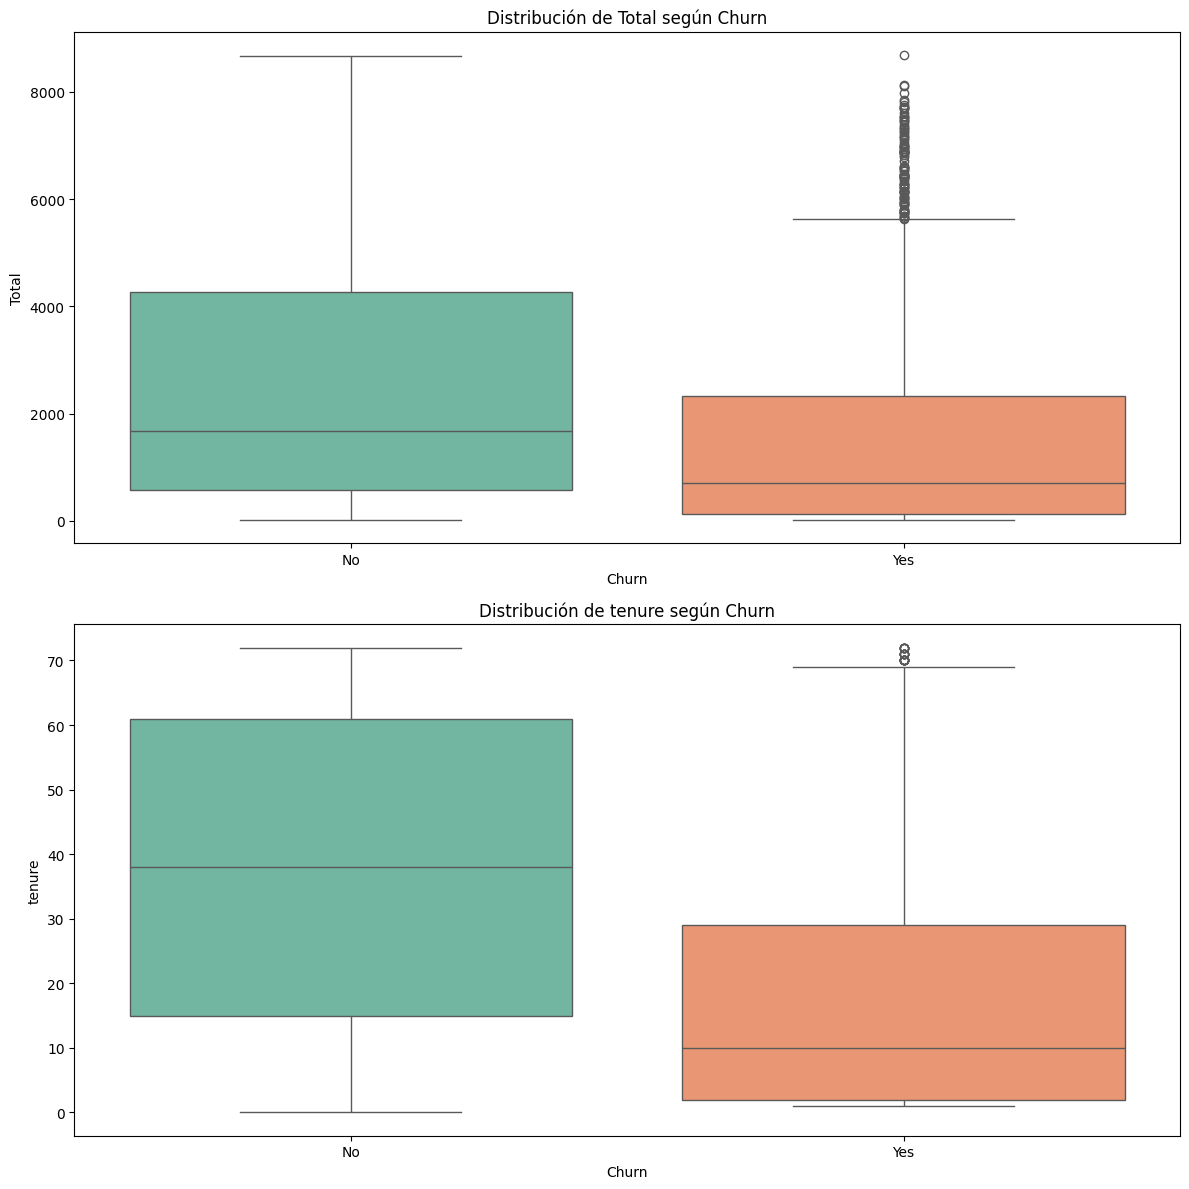

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna 'Total' a numérica si no lo está
df_clean['Total'] = pd.to_numeric(df_clean['Total'], errors='coerce')

numeric_vars = ['Total', 'tenure']

plt.figure(figsize=(12, 6 * len(numeric_vars)))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(len(numeric_vars), 1, i)
    sns.boxplot(data=df_clean, x='Churn', y=var, palette='Set2')
    plt.title(f'Distribución de {var} según Churn')
    plt.xlabel('Churn')
    plt.ylabel(var)

plt.tight_layout()
plt.show()
